# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка библиотек

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import numpy as np 
import phik
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats as st 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from numpy.random import RandomState
state = RandomState(12345) 

### Загрузка датасетов

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Знакомство с данными

In [4]:
print(data_0.info())
display(data_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
print(data_1.info())
display(data_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
print(data_2.info())
display(data_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Вывод:
1. Пропусков нет
2. Тип данных соответсвует данным в столбцах

### Предобработка 

In [7]:
datasets = [data_0, data_1, data_2]
for name in datasets:
    print(name.duplicated().sum())

0
0
0


Явных дубликатов нет

In [8]:
for name in datasets:
    print(len(name['id'].unique()))

99990
99996
99996


У некоторых месторождений разные показатели. Возможно то ошибка. Но исключать их мы не можем, тк не знаем какое верное и не хотим упускать прибыль

In [9]:
def hist_box(data, column):
    """Построение графиков распределения"""
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column])
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column])

In [10]:
def scatter_plot(data, column):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[column], data['product'], alpha=0.5)
    plt.title(f'Диаграмма рассеяния: {column} против product')
    plt.xlabel(column)
    plt.ylabel('product')
    plt.grid()
    plt.show()

#### data_0

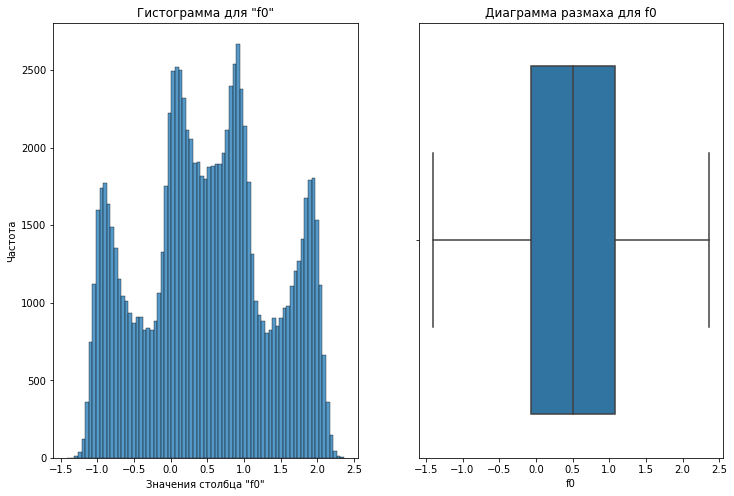

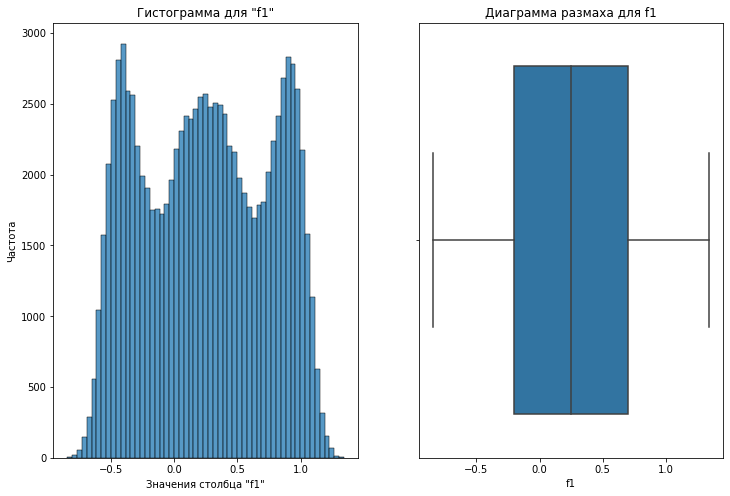

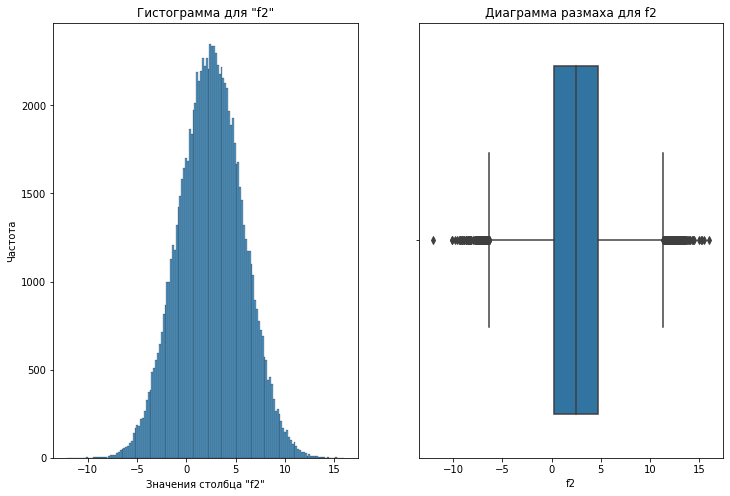

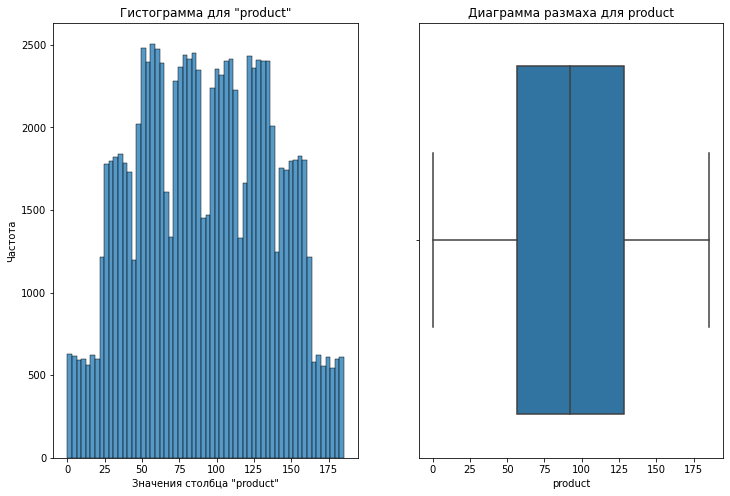

In [11]:
num_cols = ['f0', 'f1', 'f2', 'product']
for col in num_cols:
    hist_box(data_0, col)

1. Данные распределены симметрично
2. Параметр f2 распределен нормально

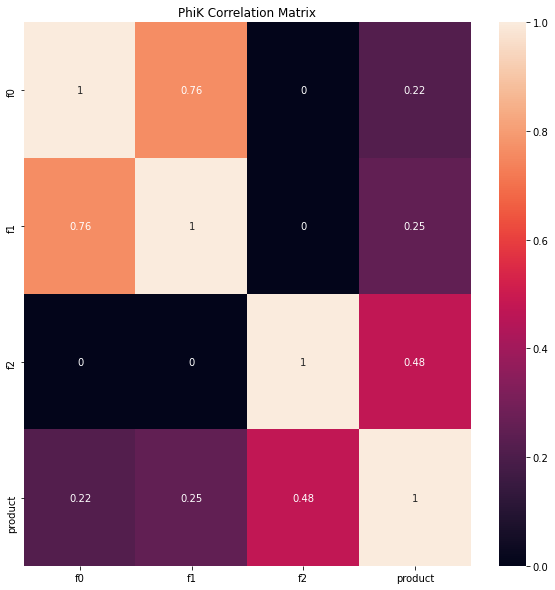

In [12]:
corr_matrix = data_0.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
 
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

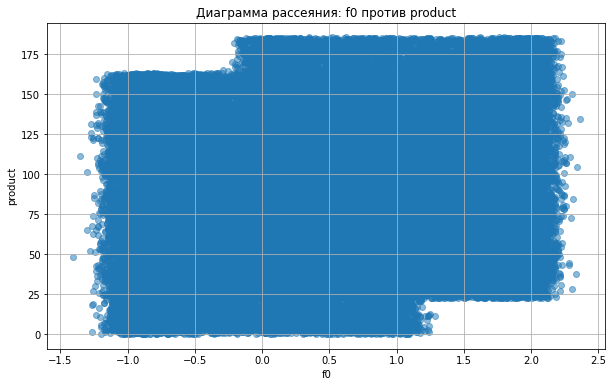

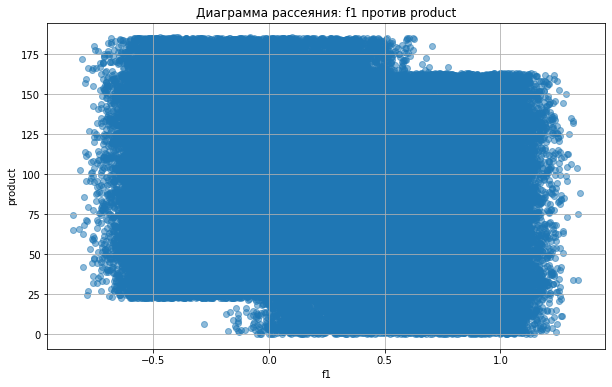

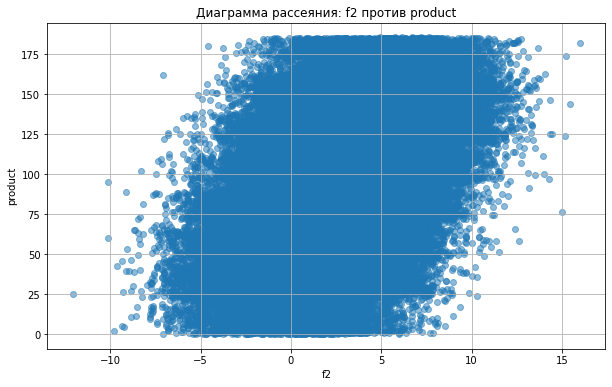

In [13]:
num_cols_scatter = ['f0', 'f1', 'f2']
for col in num_cols_scatter:
    scatter_plot(data_0, col)

1. Слабая линейная зависимость между целевым признаком и параметрами f0 и f1
2. Заметна линейная связь целевого признака с параметром f2
3. Сильная корреляция между f0 и f1

#### data_1

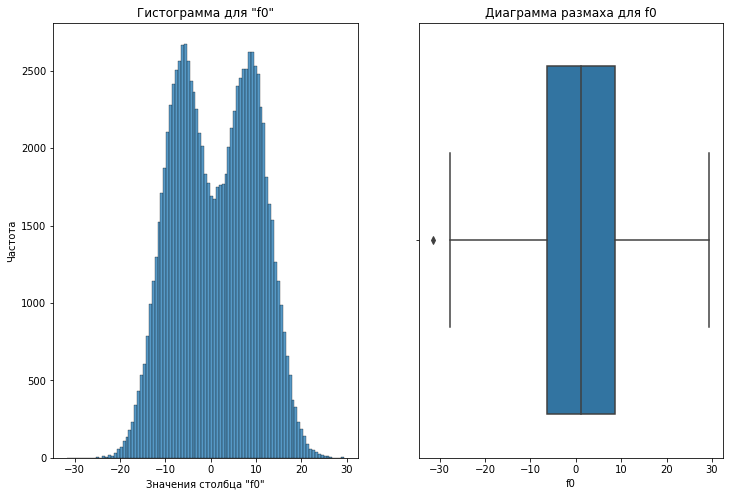

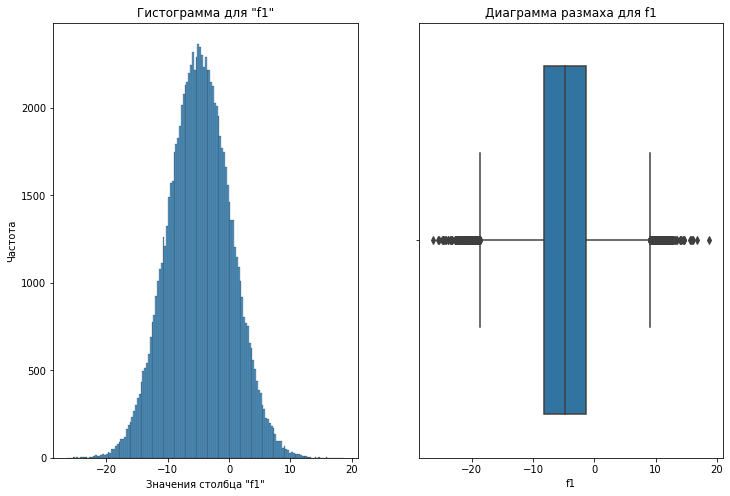

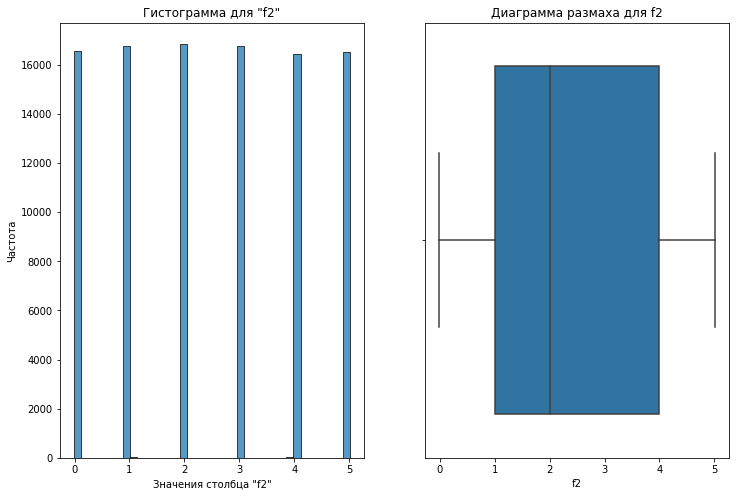

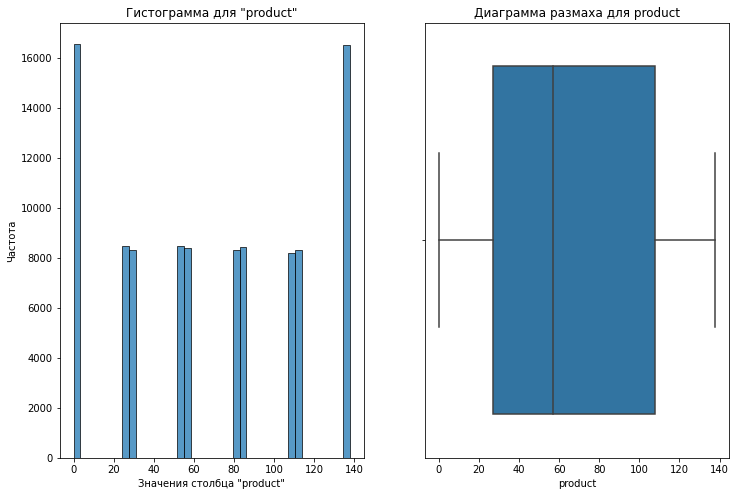

In [14]:
for col in num_cols:
    hist_box(data_1, col)

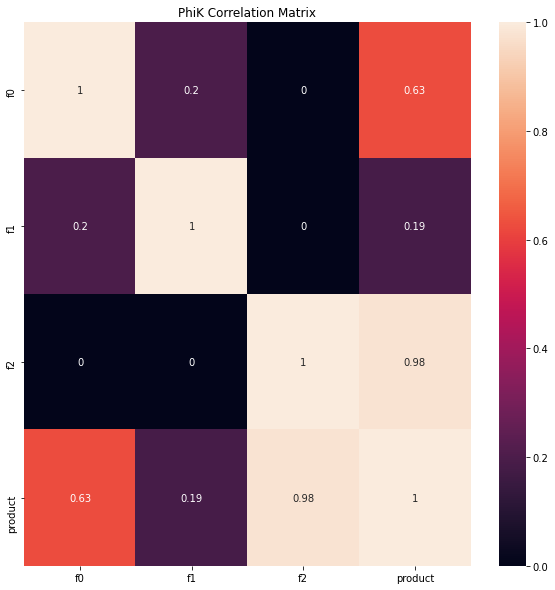

In [15]:
corr_matrix = data_1.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
 
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

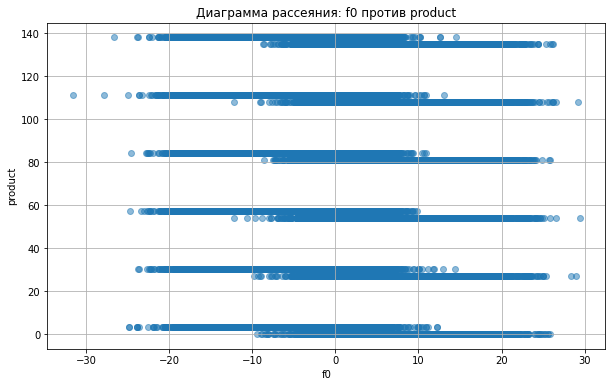

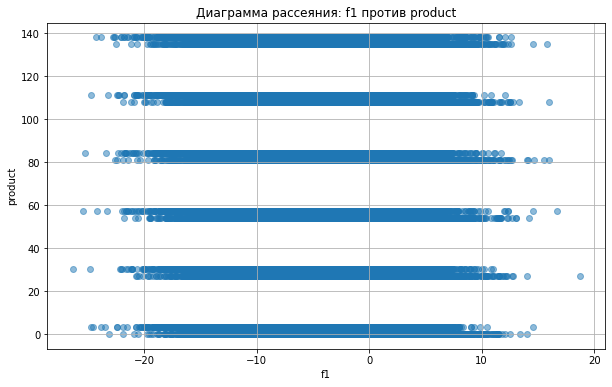

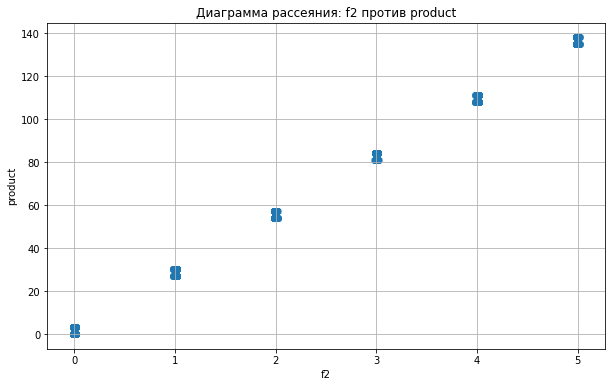

In [16]:
for col in num_cols_scatter:
    scatter_plot(data_1, col)

1. Аномалий в распределении не замечено
2. Слишком высокая корреляция между product и f2

#### data_2

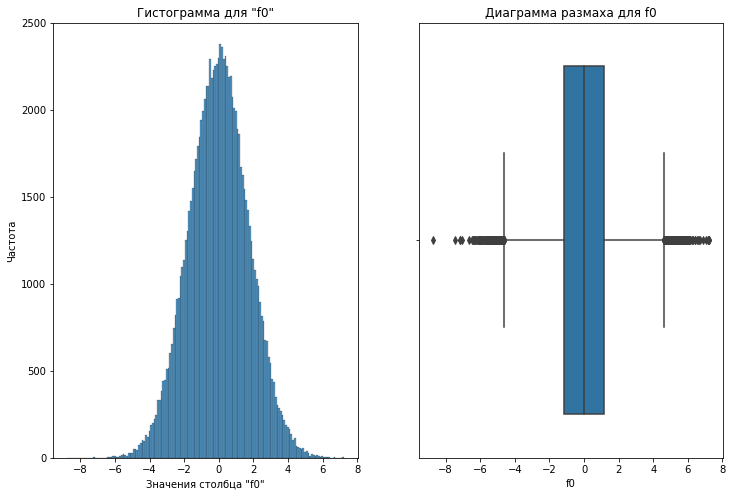

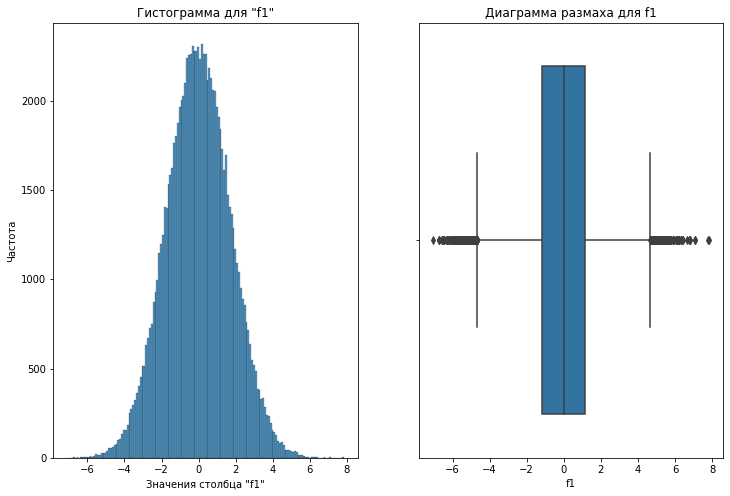

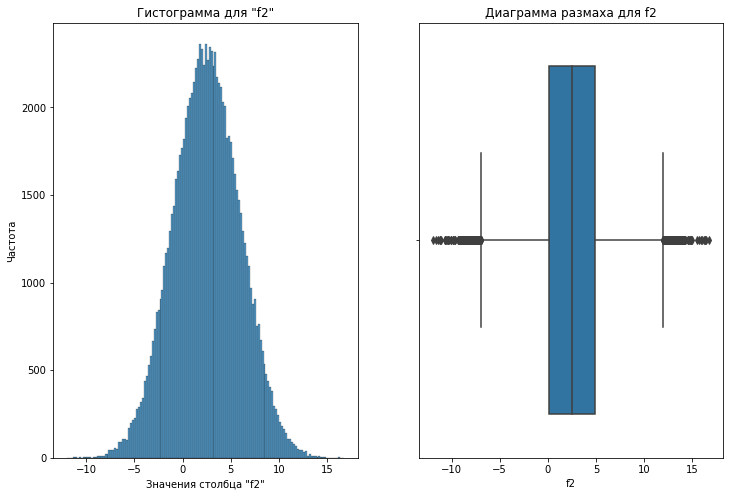

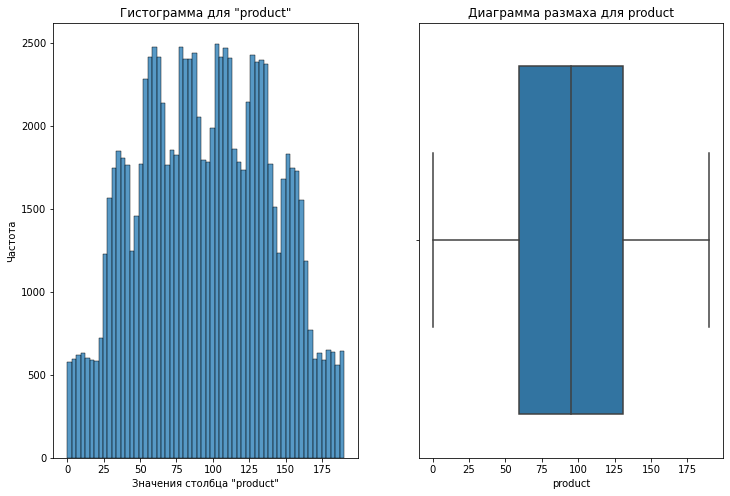

In [17]:
for col in num_cols:
    hist_box(data_2, col)

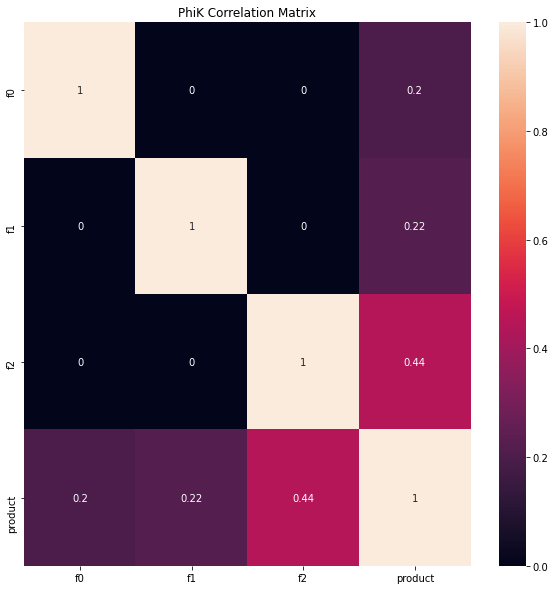

In [18]:
corr_matrix = data_2.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
 
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

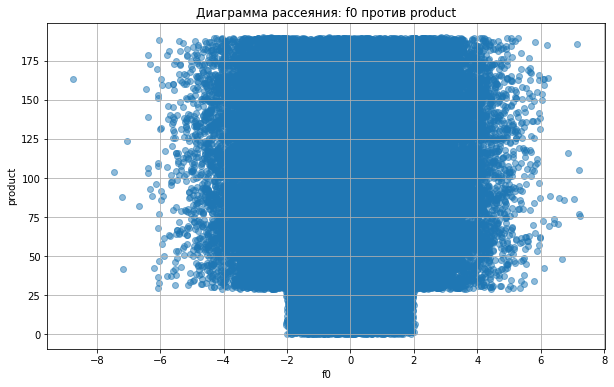

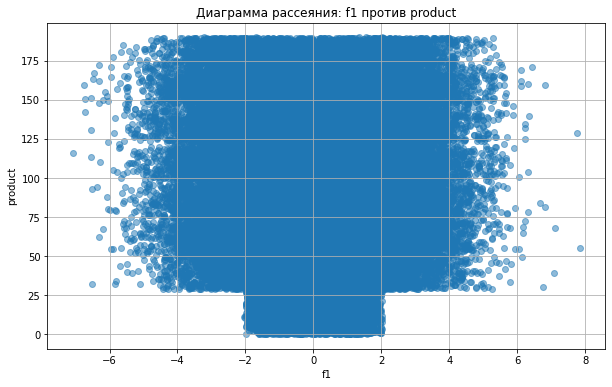

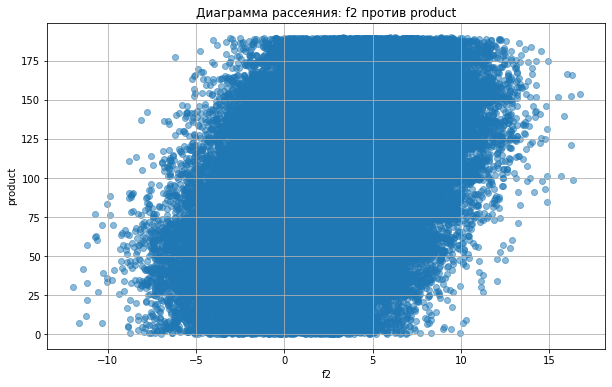

In [19]:
for col in num_cols_scatter:
    scatter_plot(data_2, col)

1. Данные распределены нормально.
2. Слабая линейная связь между f0,f1 и целевым признаком
3. Средняя корреляция между целевым признаком и f2

## Обучение и проверка модели

### Подготовка данных

In [20]:
df_0 = data_0.drop('id', axis=1)
df_1 = data_1.drop('id', axis=1)
df_2 = data_2.drop('id', axis=1)

In [21]:
print(df_0.duplicated().sum())
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())

0
0
0


Явных дубликатов после удаления id не наблюдается

In [22]:
num_cols_ = ['f0', 'f1', 'f2']

In [23]:
def model_linear(dataset, target, columns):
    X = dataset.drop(target, axis=1)
    y = dataset[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[columns])
    X_test_scaled = scaler.transform(X_test[columns]) 
    
    model  = LinearRegression()
    model.fit(X_train_scaled, y_train)
    prediction = model.predict(X_test_scaled)

    residuals = y_test - prediction
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[1].scatter(x=prediction, y=residuals, alpha=0.5)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    

    MSE = mean_squared_error(y_test, prediction)
    RMSE = mean_squared_error(y_test, prediction, squared=False)
    MAE = mean_absolute_error(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    print(f"R2 = {R2:.3f}")
    print(f"MSE = {MSE:.3f}")
    print(f"RMSE = {RMSE:.3f}")
    print(f"MAE = {MAE:.3f}")  
    
    return X_test, y_test, prediction

### Обучение моделей

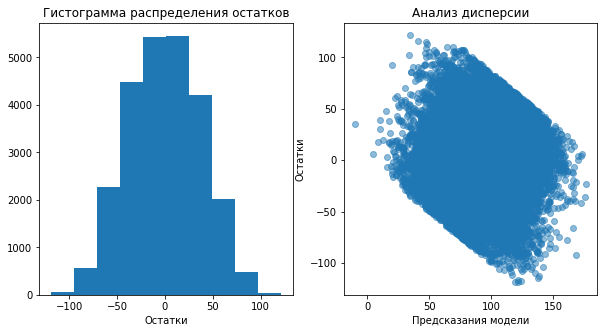

R2 = 0.273
MSE = 1425.561
RMSE = 37.757
MAE = 31.048
Средний запас предсказанного сырья: 92.4 тыс. баррелей


In [24]:
X_test_0, y_test_0, pred_0 = model_linear(df_0, 'product', num_cols_)
X_test_0['product_true'] = y_test_0
X_test_0['product_pred'] = pred_0
print('Средний запас предсказанного сырья:', round(X_test_0['product_pred'].mean(), 2), 'тыс. баррелей')

Судя по R2 модель не может предсказать точно запасы сырья. По дисперсии видно, что модель не может полностью ухватить зависимости между признаками

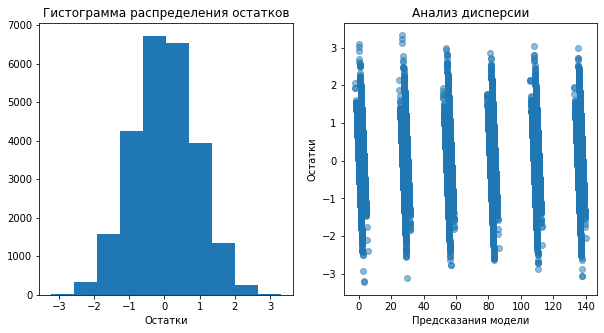

R2 = 1.000
MSE = 0.793
RMSE = 0.890
MAE = 0.717
Средний запас предсказанного сырья: 68.71 тыс. баррелей


In [25]:
X_test_1, y_test_1, pred_1 = model_linear(df_1, 'product', num_cols_)
X_test_1['product_true'] = y_test_1
X_test_1['product_pred'] = pred_1
print('Средний запас предсказанного сырья:', round(X_test_1['product_pred'].mean(), 2), 'тыс. баррелей')

У целевого признака и f2 из этого датасета очень высокая корреляция между собой, что выражается в значении R2.<br>
При этом значение метрики RMSE = 0.890

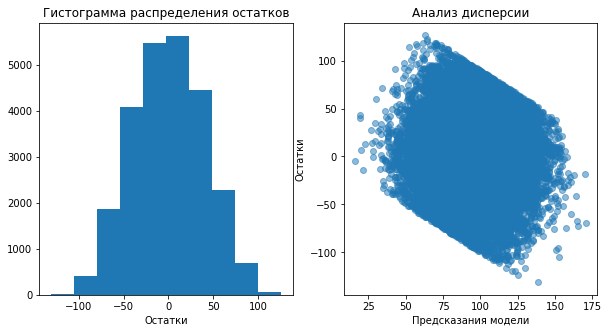

R2 = 0.196
MSE = 1611.691
RMSE = 40.146
MAE = 32.897
Средний запас предсказанного сырья: 94.77 тыс. баррелей


In [26]:
X_test_2, y_test_2, pred_2 = model_linear(df_2, 'product', num_cols_)
X_test_2['product_true'] = y_test_2
X_test_2['product_pred'] = pred_2
print('Средний запас предсказанного сырья:', round(X_test_2['product_pred'].mean(), 2), 'тыс. баррелей')

Эта модель по результатам и графикам похожа на первую

## Подготовка к расчёту прибыли

In [27]:
# бюджет на разработку скважин
budget = 10000000000 
# доход с 1 тысячи баррелей сырья
profit = 450000 

In [28]:
# достаточный объём сырья для безубыточной разработки новой скважины
enough_resources = budget / (profit * 200)
print(f'{round(enough_resources, 2)} тыс баррелей')

111.11 тыс баррелей


Каждая из моделей показала, что запасов менее рассчитанных 111.11 тыс

## Расчёт прибыли и рисков 

### Расчет прибыли

In [29]:
def revenue(dataset):
    """Рассчет прибыли с 200 скважин с наибольшим предсказанным запасом"""
    df_sort = dataset.sort_values(by= 'product_pred', ascending=False).head(200)
    amount = df_sort['product_true'].sum()
    return profit * amount - budget

In [30]:
dfs = [X_test_0, X_test_1, X_test_2]

for num, df in enumerate(dfs):
    print(f'Прибыль с региона {num} = {revenue(df)/1000:.2f} тыс. рублей')

Прибыль с региона 0 = 3359141.11 тыс. рублей
Прибыль с региона 1 = 2415086.70 тыс. рублей
Прибыль с региона 2 = 2598571.76 тыс. рублей


Наибольшая прибыль с 1го региона

### Расчет рисков

In [31]:
def bootstrap(dataset):
    values = []
    for i in range(1000):
        subsample = dataset.sample(n=500, replace=True, random_state=state)
        values.append(revenue(subsample))
    
    values = pd.Series(values)
    
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    
    mean_revenue = values.mean()
    
    sigma = np.std(values)
    
    distr = st.norm(mean_revenue, sigma)
    x = 0 
    result = distr.cdf(x)
    
    return mean_revenue, lower, upper, result

In [32]:
for num, i in enumerate(dfs):
    mean_revenue, lower, upper, result = bootstrap(i)
    print(f'Регион {num}')
    print(f'Средняя прибыль в регионе: {mean_revenue/1000:.3f} тыс. рублей') 
    print(f'Границы 95% доверительного интервала: {lower, upper}')
    print(f'Вероятность отрицательной прибыли: {result:.2%}')
    print()

Регион 0
Средняя прибыль в регионе: 406278.783 тыс. рублей
Границы 95% доверительного интервала: (-117742136.49486831, 911737050.7514055)
Вероятность отрицательной прибыли: 6.09%

Регион 1
Средняя прибыль в регионе: 441504.278 тыс. рублей
Границы 95% доверительного интервала: (35728489.280851334, 828006639.0043902)
Вероятность отрицательной прибыли: 1.50%

Регион 2
Средняя прибыль в регионе: 385213.196 тыс. рублей
Границы 95% доверительного интервала: (-164785166.1090443, 888206234.1976783)
Вероятность отрицательной прибыли: 7.87%



### Вывод
1. Наиболее выгодным регионом себя показывает Регион 1
2. Регион 1 соответствует условию "вероятность убытков меньше 2.5%"

## Вывод
Были проанализированны данные о трех регионов месторождений нефти с целью определения наиболее прибыльные и менее рискованного для разработки региона.

По каждому региона была обучения модель линейной регрессии для предсказания объёма добываемого сырья. Лучшей моделью оказалась модель для региона 1, у которой ключевая метрика RMSE составила 0.89.

Для каждого региона была рассчитана прибыль. Наиболее прибыльным оказался регион 0.

Так же были рассчитаны риски убытков. Наименее убыточным можно считать регион 1, в нем вероятность убытков составила 1.5%.

Для дальнейшей разработки месторождений стоит выбрать регион 1. Он наименее убыточен

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован